---

# <center> [Предсказание популярности песен](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset/data) (Song Popularity Prediction)

#### 1. Выбор набора данных и обоснование его выбора

Анализ популярности музыки – важная задача для лейблов и стриминговых платформ (Spotify, Apple Music и др.). Цифровой стриминг вытесняет покупки песен и физические носители, а поиск "формулы успеха" для новых треков становится ключевым.

В моей работе я прогнозирую популярность песен по шкале от 0 до 100, используя датасет с характеристиками треков (энергичность, танцевальность и др.). Выбранный датасет включает как малоизвестные песни, так и хиты с миллиардами прослушиваний, что позволяет учитывать разную динамику популярности.

---

#### 2. Выбор метрик качества и обоснование их выбора

В качестве метрик были выбраны $MSE$ и $RMSE$ - классические метрики для решения задач регрессии. Также попробую использовать метрику $R^2$, так как она дает общую оценку качества модели относительно дисперсии в данных. Фактически, данная метрика - это нормированная среднеквадратичная ошибка и если она близка к единице, то модель хорошо объясняет данные, а  если же она близка к нулю, то прогнозы сопоставимы по качеству с константным предсказанием. В основном же будем следить за RMSE, так как она соответствует размерности предсказываемых данных

---

#### 3. Бейзлайн.

Начнём с импорта всех библиотек, они будут добавляться в процессе работы. Также загрузим сам датасет и определим, какие колонки будут нашими признаками, а какая является таргетом.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
df = pd.read_csv('song_data.csv')
df

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


Описание признаков:

1. song_name: Название песни
2. song_popularity: Популярность песни, вероятно, измеренная на основе различных метрик, таких как количество прослушиваний, скачиваний и т.д.
3. song_duration_ms: Продолжительность песни в миллисекундах, обозначающая общую длительность трека.
4. acousticness: Акустичность трека, измеренная от 0 (электронная музыка) до 1 (полностью акустическая).
5. danceability: Танцевальность трека, представляющая собой метрику, насколько трек пригоден для танцев.
6. energy: Энергия трека, описывающая общую энергетику и интенсивность звучания.
7. instrumentalness: Степень, в которой трек не содержит вокальных партий. От 0 (с вокалом) до 1 (инструментальный).
8. key: Тональность трека, представленная в числовой форме (0-11), где каждое число представляет собой различные музыкальные тональности.
9. liveness: Вероятность того, что запись трека была сделана в прямом эфире или на концерте.
10. loudness: Общая громкость трека, измеряемая в децибелах (dB).
11. audio_mode: Режим аудио, указывающий на то, является ли трек больше минорным (0) или мажорным (1).
12. speechiness: Мера того, насколько в треке присутствует словесный контент или речь.
13. tempo: Темп трека, выраженный в ударам в минуту (BPM).
14. time_signature: Ритмическая структура трека, обозначающая количество ударов в такте.
15. audio_valence: Эмоциональная окраска трека, где 0 представляет собой трек с негативной окраской, а 1 - с позитивной.










Предварительно удалим строковую колонку *song_name*

In [4]:
df.drop(['song_name'], axis=1, inplace=True)

In [5]:
target = 'song_popularity'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


Константным предиктором для выбранных метрик -- среднее по таргету. Поэтому посчитаем среднее и посчитаем ошибку.

In [7]:
predict_mean = [df[target].mean()] * df.shape[0]

In [10]:
def print_error(predict, true):
    mse = mean_squared_error(predict, true)
    print("MSE: ", mse)
    print("RMSE: ", np.sqrt(mse))
    print("R^2:", r2_score(predict, true))

In [11]:
print_error(list(df[target]),(predict_mean))

MSE:  479.8322143432033
RMSE:  21.905072799313025
R^2: 0.0


Видим, что $R^2$ обнулился, что соответствует реальности, так как прогнозируемое значение является константным предиктором.

Попробуем обучить модель линейной регресси из sklearn на необработанных данных. Разделим выборку на train и test.

In [12]:
X = df[features]
y = df[target]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
print_error(model.predict(X_test), y_test)

MSE:  461.6379271397563
RMSE:  21.48576103236179
R^2: -18.280481630293767


MSE и RMSE уменьшились, однако $R^2$ стал отрицательным, и это не есть хорошо, на это есть несколько причин: модель не соответствует данным (например, зависимость нелинейная), несбалансированность данных и/или переобучение. Поэтому необходимо поработать как с данными, так и, может быть, с моделями, например, взять регрессию с регуляризацией или взять модели посложнее

#### 4-5. Улучшение бейзлайна

In [16]:
df

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [18]:
df.nunique().sort_values()

,0
audio_mode,2
time_signature,5
key,12
song_popularity,101
danceability,849
energy,1132
speechiness,1224
audio_valence,1246
liveness,1425
acousticness,3209


In [19]:
nu = df[features].nunique().sort_values()
num_cols = []
cat_cols = []

for i in range(df[features].shape[1]):
    if nu.values[i] <= 16:
        cat_cols.append(nu.index[i])
    else:
        num_cols.append(nu.index[i])

print('{} количественных & {} категориальных признаков'.format(len(num_cols),len(cat_cols)))

10 количественных & 3 категориальных признаков


In [20]:
num_cols

['danceability',
 'energy',
 'speechiness',
 'audio_valence',
 'liveness',
 'acousticness',
 'instrumentalness',
 'loudness',
 'song_duration_ms',
 'tempo']

In [21]:
cat_cols

['audio_mode', 'time_signature', 'key']

In [22]:
df.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


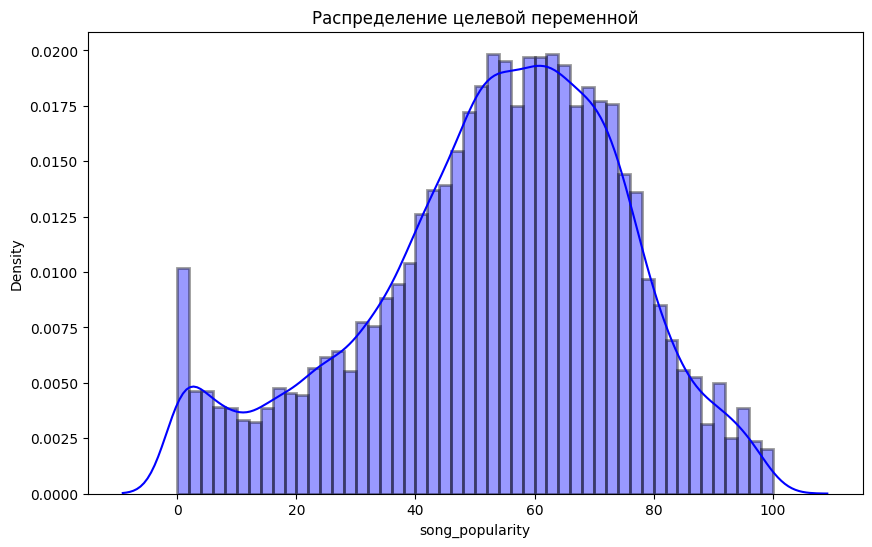

In [23]:
sns.distplot(df[target], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Распределение целевой переменной')
plt.show()

Целевая переменная, кажется, имеет нормальное распределение, среднее - в районе 60. Есть заметный выброс в нуле.

Визуализируем количественные и категориальные признаки, начнём с количественных

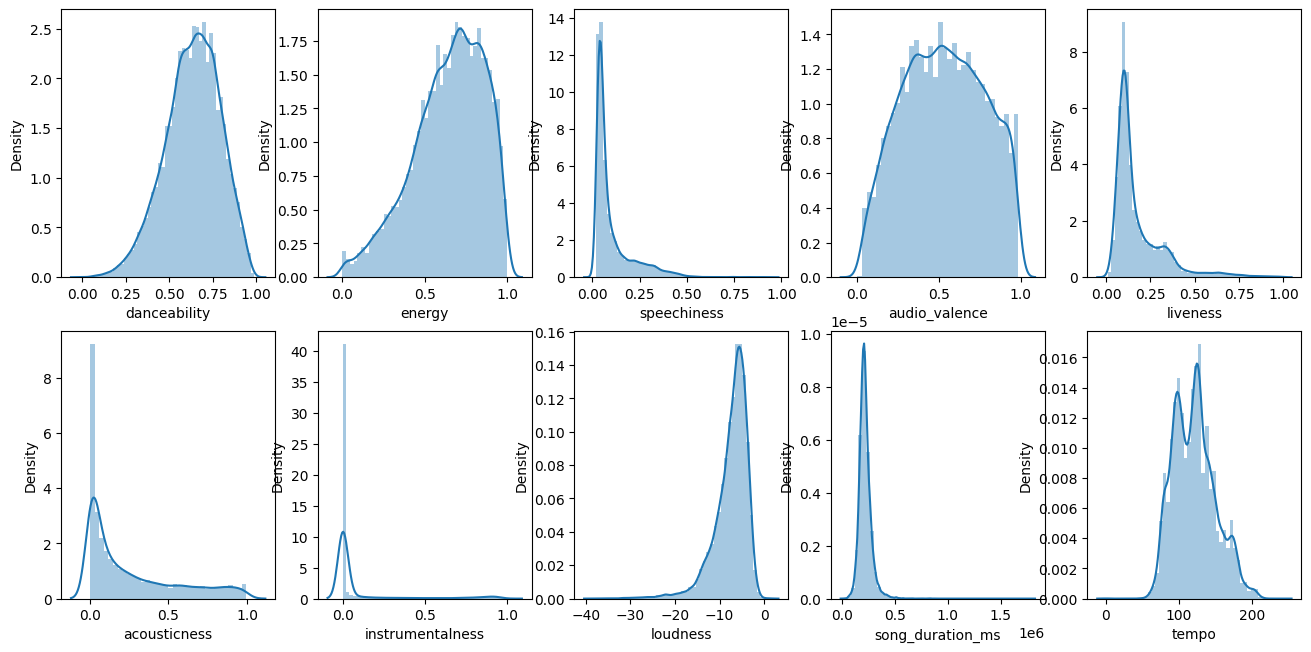

In [24]:
n = 5
plt.figure(figsize=(16, 8 * math.ceil(len(num_cols) / n)))
for i in range(len(num_cols)):
    plt.subplot(math.ceil(len(num_cols) / 3), n, i + 1)
    sns.distplot(df[num_cols[i]])
plt.show()

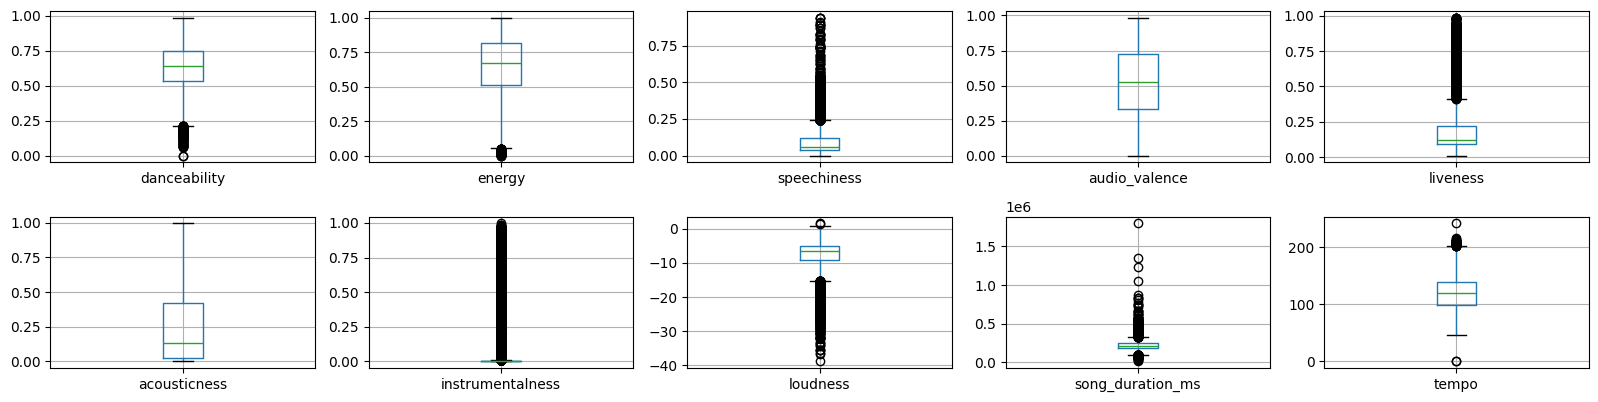

In [25]:
plt.figure(figsize=(16, 4 * math.ceil(len(num_cols) / n)))
for i in range(len(num_cols)):
    plt.subplot(math.ceil(len(num_cols) / 3), n, i + 1)
    df.boxplot(num_cols[i])
plt.tight_layout()
plt.show()

Есть некоторые гипотезы

* danceability и energy будут коррелировать
* instrumentalness не будет являться важным признаком
* instrumentalness и speechiness будут коррелировать

Категориальные признаки:

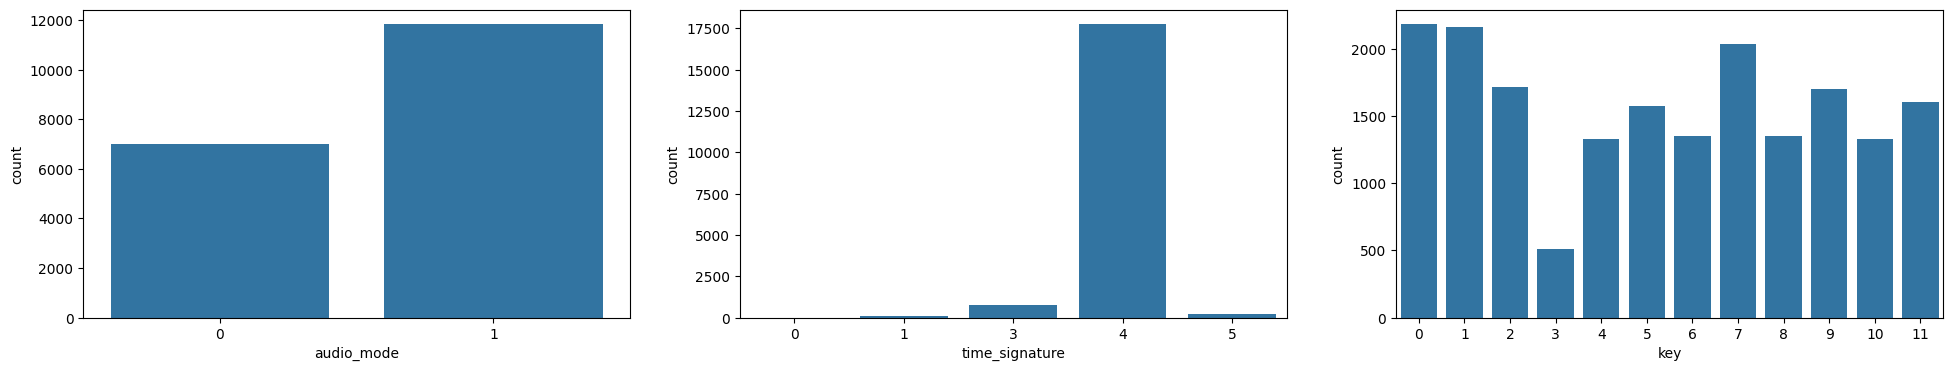

In [26]:
plt.figure(figsize=[24, 4 * math.ceil(len(cat_cols) / 3)])
for i in range(len(cat_cols)):
    plt.subplot(math.ceil(len(cat_cols) / 3), 3, i + 1)
    sns.countplot(df, x=cat_cols[i])
plt.show()

Ещё гипотезы

* time_signature не будет являться важным признаком

In [27]:
rs, cs = original_df.shape

df.drop_duplicates(inplace=True)

print(f'Удалённые: {rs - df.shape[0]}')

Удалённые: 3911


Проверим на пустые значения

In [28]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
song_popularity                   0         0.0
song_duration_ms                  0         0.0
acousticness                      0         0.0
danceability                      0         0.0
energy                            0         0.0
instrumentalness                  0         0.0
key                               0         0.0
liveness                          0         0.0
loudness                          0         0.0
audio_mode                        0         0.0
speechiness                       0         0.0
tempo                             0         0.0
time_signature                    0         0.0
audio_valence                     0         0.0


Применяем one-hot кодирование для категориальных признаков

In [29]:
df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values

for i in [i for i in cat_cols if i not in ecc]:
    if df3[i].nunique() == 2:
        df3[i] = pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if df3[i].nunique() > 2 and df3[i].nunique() < 17:
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))], axis=1)

df3.shape

(14924, 27)

In [30]:
df1 = df3.copy()

In [31]:
for i in num_cols:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3 + (1.5 * IQR))]
    df1 = df1[df1[i] >= (Q1 - (1.5 * IQR))]
    df1 = df1.reset_index(drop=True)

In [32]:
print('До очистки {}'.format(df3.shape[0]))
print('После: {}'.format(df1.shape[0]))
df1.head()

До очистки 14924
После: 8950


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,True,0.0294,...,False,False,False,False,False,False,True,False,False,False
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,False,0.0498,...,False,True,False,False,False,False,False,False,False,False
2,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,True,0.1070,...,False,False,False,False,False,False,False,False,False,False
3,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,True,0.0313,...,False,False,False,False,False,False,False,False,True,False
4,80,235893,0.008950,0.316,0.945,0.000002,0.3960,-3.169,False,0.1240,...,False,False,True,False,False,False,False,False,False,False


In [33]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,True,0.0294,...,False,False,False,False,False,False,True,False,False,False
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,False,0.0498,...,False,True,False,False,False,False,False,False,False,False
2,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,True,0.1070,...,False,False,False,False,False,False,False,False,False,False
3,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,True,0.0313,...,False,False,False,False,False,False,False,False,True,False
4,80,235893,0.008950,0.316,0.945,0.000002,0.3960,-3.169,False,0.1240,...,False,False,True,False,False,False,False,False,False,False


In [34]:
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.reset_index(drop=True, inplace=True)

In [35]:
print('Original set: ', X.shape, y.shape)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Original set:  (8950, 26) (8950,)
Train:  (7160, 26) (7160,)
Test:  (1790, 26) (1790,)


In [36]:
std = StandardScaler()

In [37]:
X_train_std = std.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X.columns)
X_train_std.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,...,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03
mean,-2.143537e-16,-9.551639e-17,-4.381349e-16,-1.359558e-16,-2.480945e-18,-8.782546e-17,-9.824543e-17,1.984756e-17,1.081692e-16,-1.429024e-16,...,-5.656555e-17,-1.587805e-17,-9.824543e-17,-2.927515e-17,-1.389329e-17,7.591693e-17,4.465702e-17,5.185176e-17,-7.939025e-17,-2.431326e-17
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,...,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00
min,-2.625387e+00,-9.181177e-01,-2.918774e+00,-3.131156e+00,-3.425841e-01,-1.575563e+00,-2.825473e+00,-1.348254e+00,-9.812680e-01,-2.528553e+00,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
25%,-6.702830e-01,-8.223387e-01,-6.452384e-01,-6.864460e-01,-3.425841e-01,-6.881147e-01,-5.876500e-01,-1.348254e+00,-6.975836e-01,-7.615380e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
50%,-6.177447e-02,-4.150227e-01,5.798743e-02,1.271097e-01,-3.411082e-01,-3.751120e-01,1.864114e-01,7.417001e-01,-4.002151e-01,-1.426259e-02,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
75%,6.146981e-01,5.921024e-01,7.219555e-01,8.042306e-01,-2.673929e-01,4.767485e-01,7.447833e-01,7.417001e-01,2.966273e-01,6.418977e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
max,2.716562e+00,2.672887e+00,2.386143e+00,1.703690e+00,6.650948e+00,2.864200e+00,2.376364e+00,7.417001e-01,3.368207e+00,2.773299e+00,...,3.109765e+00,5.899152e+00,3.607179e+00,3.253577e+00,3.569706e+00,2.774865e+00,3.540476e+00,3.086975e+00,3.743058e+00,3.361905e+00


In [38]:
X_test_std = std.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X.columns)
X_test_std.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,...,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,0.036125,-0.014032,0.006938,0.028758,0.010602,-0.058353,0.026948,0.009632,-0.023773,-0.005688,...,-0.012939,0.006781,-0.001628,0.024867,-0.058608,-0.015326,0.025095,0.036205,-0.022964,-0.003066
std,0.971755,0.975985,0.990170,0.974326,1.002490,0.982153,0.979911,0.997307,0.968979,1.002542,...,0.981985,1.019502,0.997564,1.035975,0.896783,0.981478,1.040064,1.048494,0.959254,0.995564
min,-2.491247,-0.918115,-2.932429,-2.934083,-0.342584,-1.543058,-2.781757,-1.348254,-0.972847,-2.236695,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
25%,-0.613785,-0.815321,-0.624756,-0.610649,-0.342584,-0.734631,-0.562450,-1.348254,-0.703373,-0.755222,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
50%,-0.024516,-0.425960,0.064815,0.149849,-0.341076,-0.425551,0.223624,0.741700,-0.412847,-0.021330,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
75%,0.611647,0.586634,0.733904,0.809284,-0.262995,0.373068,0.727351,0.741700,0.323469,0.580851,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
max,2.685640,2.669241,2.345178,1.693583,6.608043,2.852991,2.786427,0.741700,3.368207,2.675691,...,3.109765,5.899152,3.607179,3.253577,3.569706,2.774865,3.540476,3.086975,3.743058,3.361905


Посмотрим на корреляцию признаков

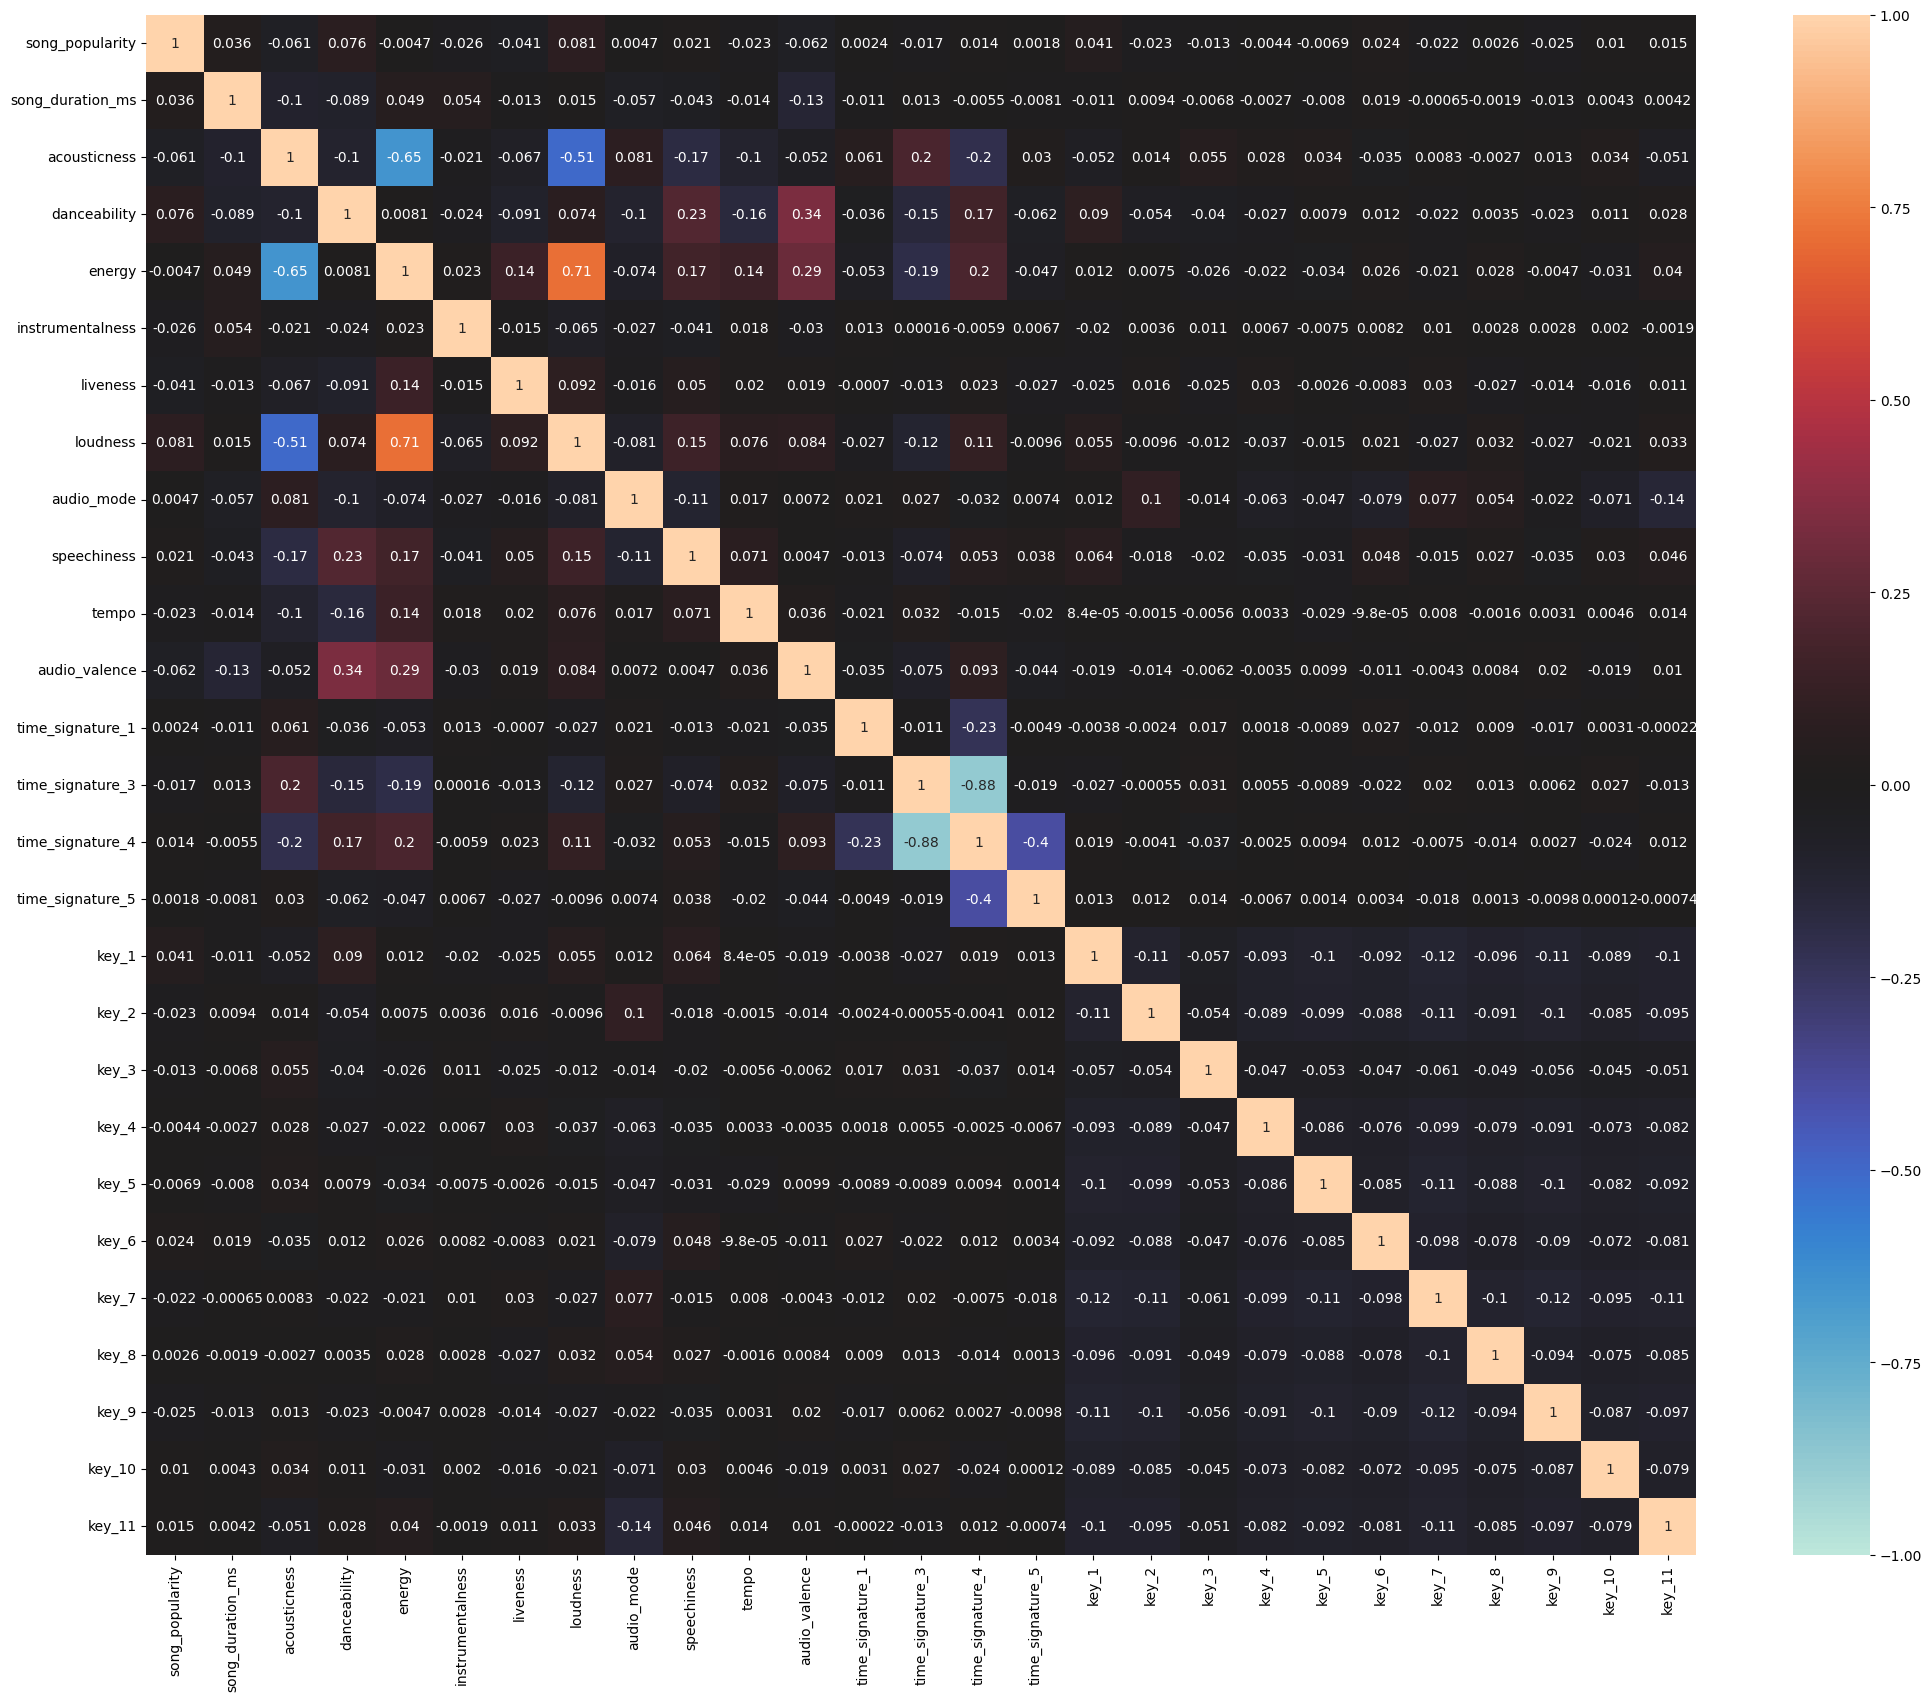

In [39]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Как ни странно, но danceability и energy, а также instrumentalness и speechiness не коррелируют, однако коррелируют другие, более неожиданные признаки.

Видно, что некоторые признаки коррелируют друг с другом, для того, чтобы избавиться от этого, можно применить следующее:

1. Variance Inflation Factor (VIF)
2. Recursive Feature Elimination (RFE)
3. Использование PCA

Рассмотрим первые два способа

##### 1. VIF

Отброшенные признаки:  ['time_signature_4', 'energy', 'key_7', 'acousticness', 'danceability', 'key_1', 'key_11', 'key_9', 'key_2', 'loudness', 'audio_mode', 'key_5', 'speechiness', 'audio_valence', 'key_4', 'key_6', 'key_3', 'key_8']


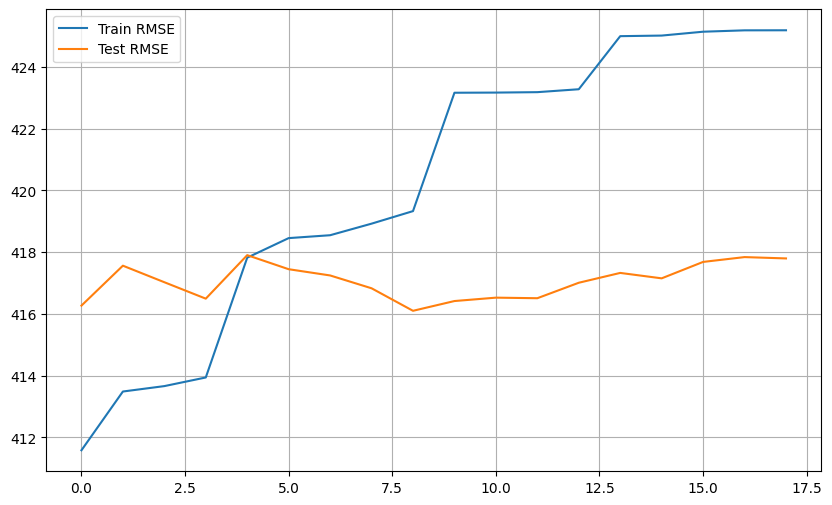

In [42]:
Trr = []
Tss = []
n = 3
drop = []

for i in range(len(X_train_std.columns)):
    vif = pd.DataFrame()
    X = X_train_std.drop(drop,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1] > 1:
        drop.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(X_train_std.drop(drop,axis=1), y_train)
        pred_train = LR.predict(X_train_std.drop(drop, axis=1))
        pred_test = LR.predict(X_test_std.drop(drop, axis=1))
        Trr.append(mean_squared_error(y_train, pred_train))
        Tss.append(mean_squared_error(y_test, pred_test))

print('Отброшенные признаки: ', drop)

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

Как ни странно, danceability и energy оба были отброшены. Также оказался ненужным признак speechiness, который по предположению должен был коррелировать с instrumentalness. Также был отброшен один из time_signature, а именно 4 столбец. В целом было отброшено довольно много признаков.

##### 2. RFE

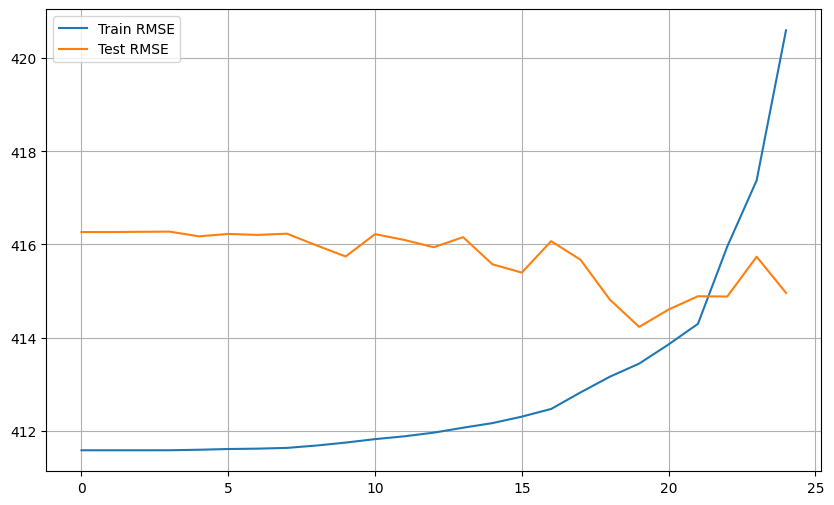

In [44]:
Trr = []
Tss = []
n = 3

for i in range(df.shape[1] - 2):
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select = X_train_std.shape[1]-i)
    rfe = rfe.fit(X_train_std, y_train)
    LR = LinearRegression()
    LR.fit(X_train_std.loc[:, rfe.support_], y_train)
    pred_train = LR.predict(X_train_std.loc[:, rfe.support_])
    pred_test = LR.predict(X_test_std.loc[:, rfe.support_])
    Trr.append(mean_squared_error(y_train, pred_train))
    Tss.append(mean_squared_error(y_test, pred_test))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

In [45]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=X_train_std.shape[1] - df.shape[1] + 10)
rfe = rfe.fit(X_train_std, y_train)

LR = LinearRegression()
LR.fit(X_train_std.loc[:, rfe.support_], y_train)

pred_train = LR.predict(X_train_std.loc[:, rfe.support_])
pred_test = LR.predict(X_test_std.loc[:, rfe.support_])

print_error(y_train, pred_train)
print_error(y_test, pred_test)

MSE:  412.82309618236286
RMSE:  20.318048532828218
R^2: 0.03428346354806122
MSE:  415.67201508153374
RMSE:  20.388036077109874
R^2: 0.004839846432919126


In [46]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5, 6]), columns=['Train-R2', 'Test-R2',
                                                                            'Train-MSE', 'Test-MSE',
                                                                            'Train-RMSE', 'Test-RMSE'])
rc = np.random.choice(X_train_std.loc[:, X_train_std.nunique() >= 50].columns.values, 3, replace=False)

In [47]:
def Evaluate(n, pred_train, pred_test):
    plt.figure(figsize=(15, 6))
    for e,i in enumerate(rc):
        plt.subplot(2, 3, e + 1)
        plt.scatter(y=y_train, x=X_train_std[i], label='Actual')
        plt.scatter(y=pred_train, x=X_train_std[i], label='Prediction')
        plt.legend()
    plt.show()

    print('\n\nTraining Set Metrics')
    print('\nR2-Score on Training set:                          ', round(r2_score(y_train, pred_train), 20))
    print('Mean Squared Error (MSE) on Training set:          ', round(mean_squared_error(y_train, pred_train), 20))
    print('Root Mean Squared Error (RMSE) on Training set:    ', round(np.sqrt(mean_squared_error(y_train, pred_train)), 20))

    print('\n\nTesting Set Metrics')
    print('\nR2-Score on Testing set:                          ', round(r2_score(y_test, pred_test), 20))
    print('Mean Squared Error (MSE) on Testing set:          ', round(mean_squared_error(y_test, pred_test), 20))
    print('Root Mean Squared Error (RMSE) on Testing set:    ', round(np.sqrt(mean_squared_error(y_test, pred_test)), 20))

    if n != -1:
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-R2']   = round(r2_score(y_train, pred_train), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-R2']    = round(r2_score(y_test, pred_test), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-MSE']  = round(mean_squared_error(y_train, pred_train), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-MSE']   = round(mean_squared_error(y_test, pred_test), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RMSE'] = round(np.sqrt(mean_squared_error(y_train, pred_train)), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RMSE']  = round(np.sqrt(mean_squared_error(y_test, pred_test)), 20)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    sns.distplot((y_train - pred_train))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1, 2, 2)
    plt.scatter(y_train, pred_train)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

In [48]:
def EvaluateS(n, pred_train, pred_test, v=250):
    plt.figure(figsize=(15, 6))
    for e,i in enumerate(rc):
        plt.subplot(2, 3, e + 1)
        plt.scatter(y=y_train[:v], x=X_train_std[:v][i], label='Actual')
        plt.scatter(y=pred_train, x=X_train_std[:v][i], label='Prediction')
        plt.legend()
    plt.show()

    print('\n\nTraining Set Metrics')
    print('\nR2-Score on Training set:                          ', round(r2_score(y_train[:v], pred_train), 20))
    print('Mean Squared Error (MSE) on Training set:          ', round(mean_squared_error(y_train[:v], pred_train), 20))
    print('Root Mean Squared Error (RMSE) on Training set:    ', round(np.sqrt(mean_squared_error(y_train[:v], pred_train)), 20))

    print('\n\nTesting Set Metrics')
    print('\nR2-Score on Testing set:                          ', round(r2_score(y_test[:v], pred_test), 20))
    print('Mean Squared Error (MSE) on Testing set:          ', round(mean_squared_error(y_test[:v], pred_test), 20))
    print('Root Mean Squared Error (RMSE) on Testing set:    ', round(np.sqrt(mean_squared_error(y_test[:v], pred_test)), 20))

    if n != -1:
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-R2']   = round(r2_score(y_train[:v], pred_train), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-R2']    = round(r2_score(y_test[:v], pred_test), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-MSE']  = round(mean_squared_error(y_train[:v], pred_train), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-MSE']   = round(mean_squared_error(y_test[:v], pred_test), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RMSE'] = round(np.sqrt(mean_squared_error(y_train[:v], pred_train)), 20)
        Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RMSE']  = round(np.sqrt(mean_squared_error(y_test[:v], pred_test)), 20)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    sns.distplot((y_train[:v] - pred_train))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1, 2, 2)
    plt.scatter(y_train[:v], pred_train)
    plt.plot([y_train[:v].min(), y_train[:v].max()], [y_train[:v].min(), y_train[:v].max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

##### a. KNN

In [50]:
from sklearn.neighbors import KNeighborsRegressor

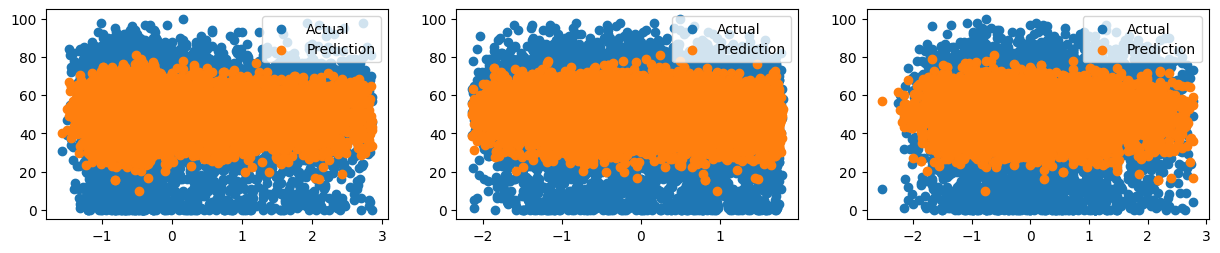



Training Set Metrics

R2-Score on Training set:                           0.2395862805197505
Mean Squared Error (MSE) on Training set:           325.0605474860336
Root Mean Squared Error (RMSE) on Training set:     18.029435584233735


Testing Set Metrics

R2-Score on Testing set:                           -0.1797759492454798
Mean Squared Error (MSE) on Testing set:           492.7848491620112
Root Mean Squared Error (RMSE) on Testing set:     22.198757829257275


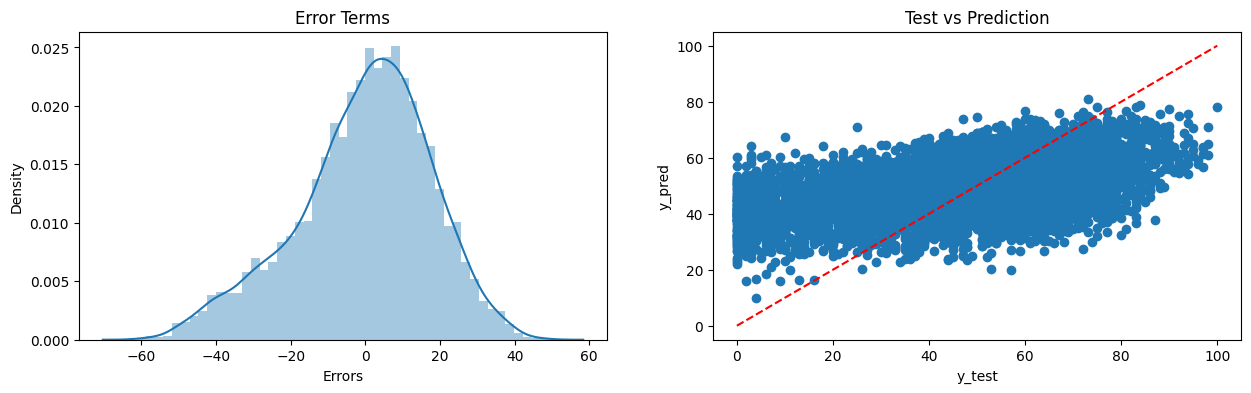

In [51]:
KNN = KNeighborsRegressor()
KNN.fit(X_train_std, y_train)
pred_train = KNN.predict(X_train_std)
pred_test = KNN.predict(X_test_std)

Evaluate(0, pred_train, pred_test)

##### b. Linear Regression

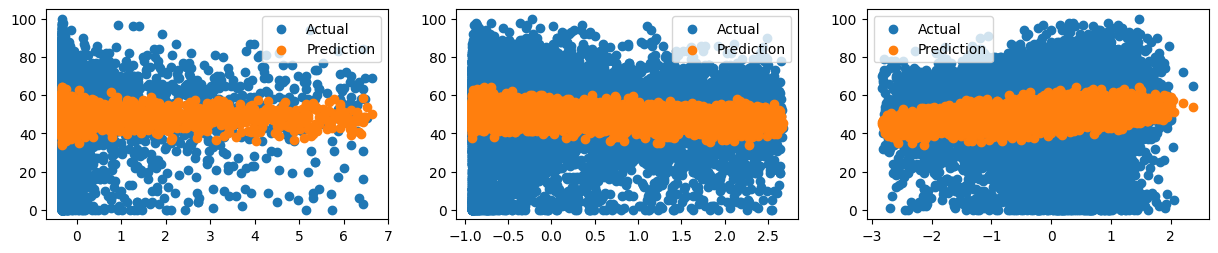



Training Set Metrics

R2-Score on Training set:                           0.03718837012062659
Mean Squared Error (MSE) on Training set:           411.58131095849905
Root Mean Squared Error (RMSE) on Training set:     20.28746684429821


Testing Set Metrics

R2-Score on Testing set:                           0.0033984544902754266
Mean Squared Error (MSE) on Testing set:           416.27407525363105
Root Mean Squared Error (RMSE) on Testing set:     20.402795770522015


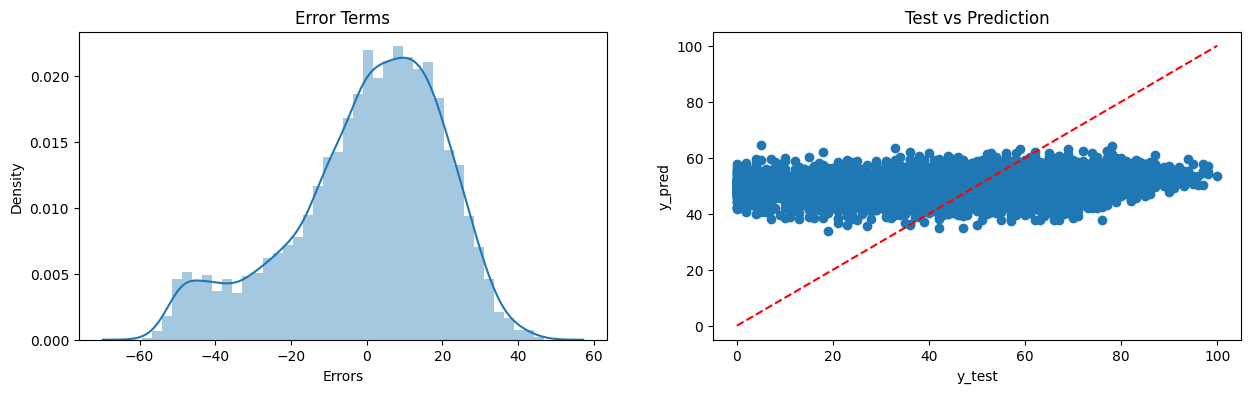

In [ ]:
MLR = LinearRegression().fit(X_train_std,y_train)
pred_train = MLR.predict(X_train_std)
pred_test = MLR.predict(X_test_std)

Evaluate(0, pred_train, pred_test)

##### c. Ridge Regression Model

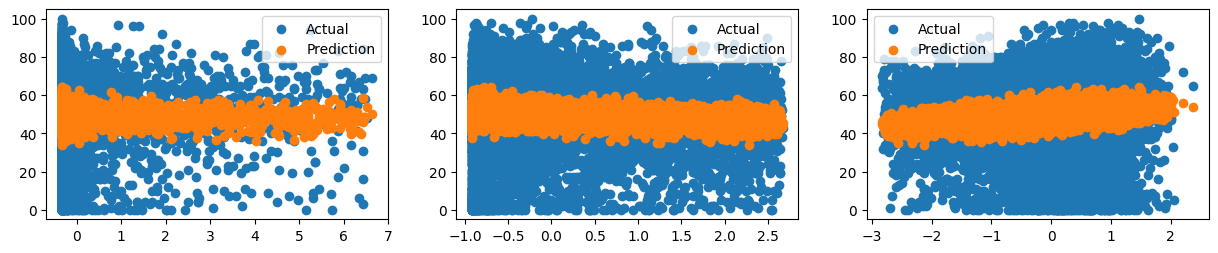



Training Set Metrics

R2-Score on Training set:                           0.037189091772393934
Mean Squared Error (MSE) on Training set:           411.5810024678543
Root Mean Squared Error (RMSE) on Training set:     20.28745924131098


Testing Set Metrics

R2-Score on Testing set:                           0.0034207109152710746
Mean Squared Error (MSE) on Testing set:           416.2647788876207
Root Mean Squared Error (RMSE) on Testing set:     20.40256794836426


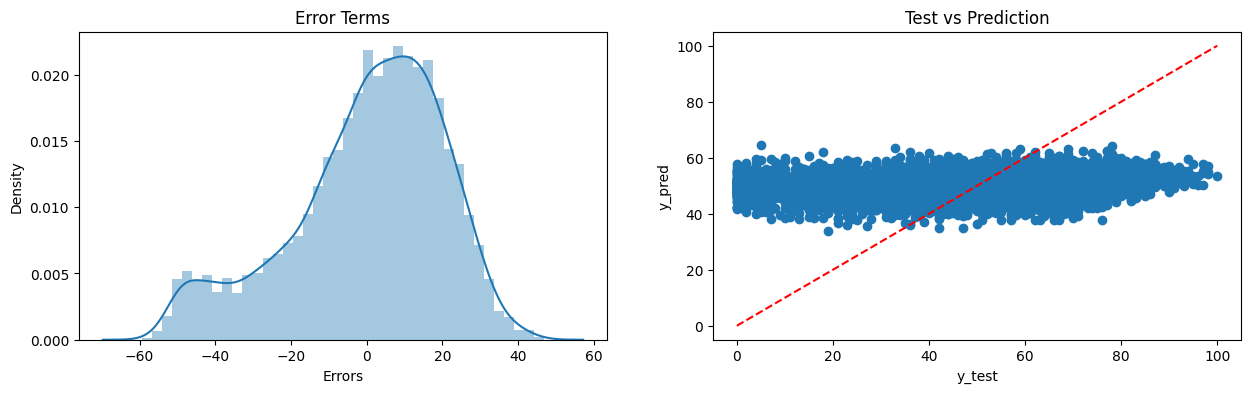

In [ ]:
RLR = Ridge().fit(X_train_std,y_train)
pred_train = RLR.predict(X_train_std)
pred_test = RLR.predict(X_test_std)

Evaluate(1, pred_train, pred_test)

##### e. Own realisation

In [ ]:
class OwnLinearRegression:
    def __init__(self, alpha=1.0, tolerance=0.0001, max_iter=1000, learning_rate=0.01):
        self._alpha = alpha
        self._tolerance = tolerance
        self._learning_rate = learning_rate
        self._max_iter = max_iter

    def fit(self, X, y):
        y = np.reshape(np.array(y), (len(y), 1))
        n_features = X.shape[1]
        X_augmented = np.c_[X, np.ones(X.shape[0])]
        self.weights = np.random.randn(n_features + 1, 1)
        prev_weights = None
        updated_weights = self.weights
        iteration = 0
        while iteration < self._max_iter and (prev_weights is None or np.sum((prev_weights - updated_weights) ** 2) >= self._tolerance):
            prev_weights = updated_weights
            gradient = 2 * X_augmented.T @ (X_augmented @ prev_weights - y) / X.shape[0]
            regularization_term = self._alpha * prev_weights
            updated_weights = prev_weights - self._learning_rate * (gradient + regularization_term)
            self.weights = updated_weights
            iteration += 1

    def predict(self, X):
        n_features = X.shape[1]
        X_augmented = np.c_[X, np.ones(X.shape[0])]
        return (X_augmented @ self.weights).squeeze(1)

In [ ]:
OLR = OwnLinearRegression()
OLR.fit(X_train_std, y_train)

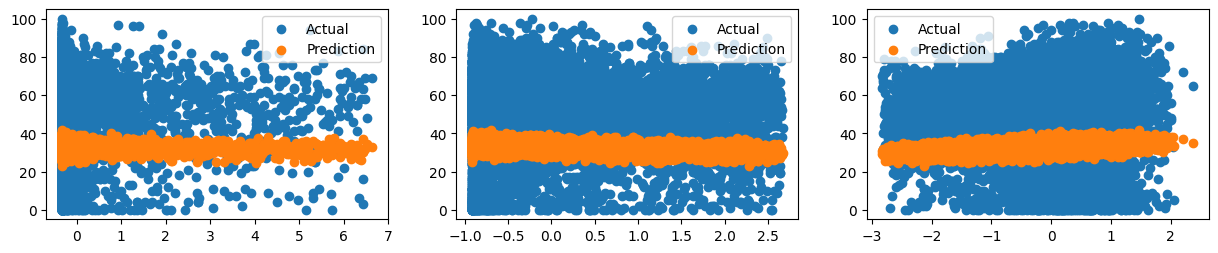



Training Set Metrics

R2-Score on Training set:                           -0.6490179295809524
Mean Squared Error (MSE) on Training set:           704.9197788938532
Root Mean Squared Error (RMSE) on Training set:     26.550325400903343


Testing Set Metrics

R2-Score on Testing set:                           -0.7316703741728496
Mean Squared Error (MSE) on Testing set:           723.3076116535867
Root Mean Squared Error (RMSE) on Testing set:     26.89437881144658


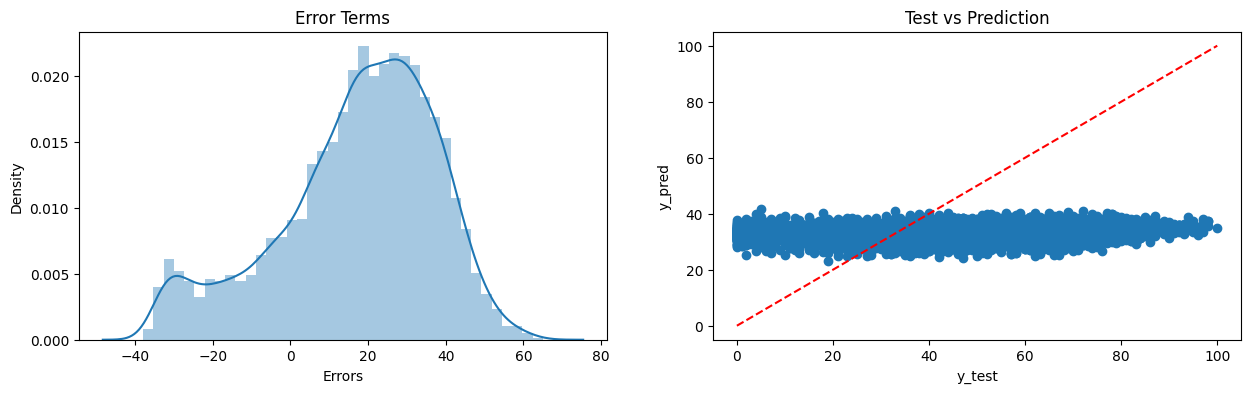

In [ ]:
pred_train = OLR.predict(X_train_std)
pred_test = OLR.predict(X_test_std)

Evaluate(4, pred_train, pred_test)

Сравним модели по метрикам

In [ ]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Linear Regression (LR)', 'Ridge Linear Regression (RLR)', 'Lasso Linear Regression (LLR)', 'Elastic-Net Regression (ENR)', 'Own realisation']
EMC

,Train-R2,Test-R2,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Linear Regression (LR),0.037188,0.003398,411.581311,416.274075,20.287467,20.402796
Ridge Linear Regression (RLR),0.037189,0.003421,411.581002,416.264779,20.287459,20.402568
Lasso Linear Regression (LLR),0.015140,0.007117,421.006445,414.720801,20.518442,20.364695
Elastic-Net Regression (ENR),0.019205,0.007624,419.268776,414.508898,20.476054,20.359492
Own realisation,-0.649018,-0.731670,704.919779,723.307612,26.550325,26.894379


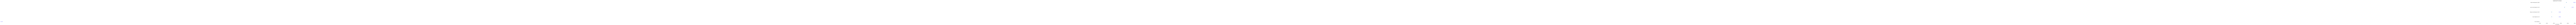

In [ ]:
R2 = round(EMC['Test-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('Сравнение R2-метрик')
plt.xlabel('R2-метрика')
for i, v in enumerate(R2):
    plt.text(v+0.002, i-0.05, str(v), color='blue')
plt.xlim([0,0.01])
plt.show()

**Inference:** From the above plot, it is clear that the polynomial regresion models have the highest explainability power  to understand the dataset.

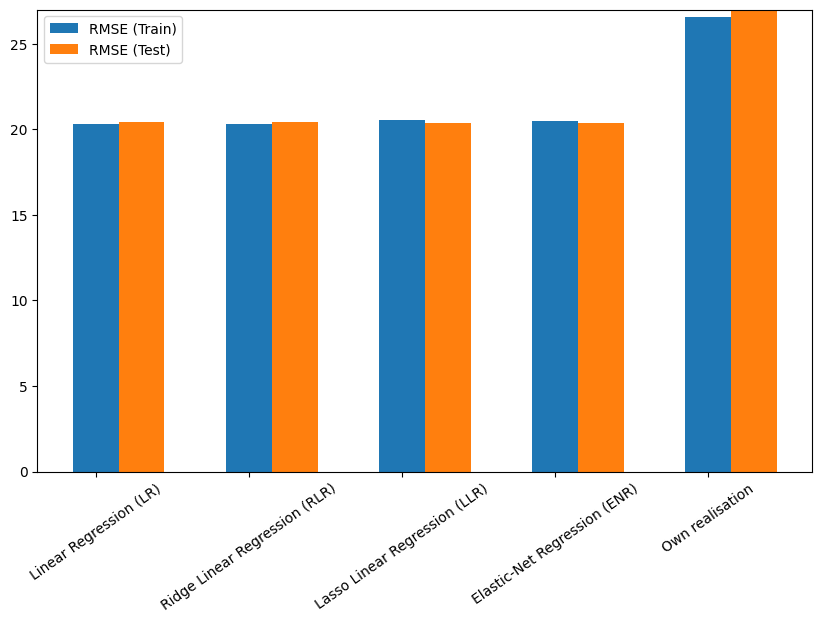

In [ ]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s = 5
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[4]].values, width=0.3, label='RMSE (Train)')
plt.bar(np.arange(5) + 0.3, Model_Evaluation_Comparison_Matrix[cc[5]].values, width=0.3, label='RMSE (Test)')
plt.xticks(np.arange(5), EMC.index, rotation=35)
plt.legend()
plt.ylim([0,27])
plt.show()

Линейная регрессия средне справилась с задачей, предсказания (судя по $R^2$) близки к константному предиктору, так как метрика почти на нуле. Попробуем использовать более сложные модели.

In [ ]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([6, 6]), columns=['Train-R2','Test-R2',
                                                                            'Train-MSE','Test-MSE',
                                                                            'Train-RMSE','Test-RMSE'])

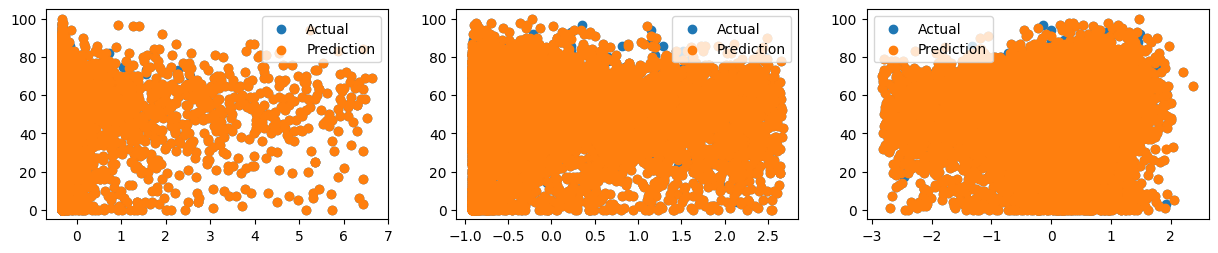



Training Set Metrics

R2-Score on Training set:                           0.9842263963085024
Mean Squared Error (MSE) on Training set:           6.742877094972067
Root Mean Squared Error (RMSE) on Training set:     2.5967050458171155


Testing Set Metrics

R2-Score on Testing set:                           -0.9777331432385027
Mean Squared Error (MSE) on Testing set:           826.0864525139665
Root Mean Squared Error (RMSE) on Testing set:     28.74171972088599


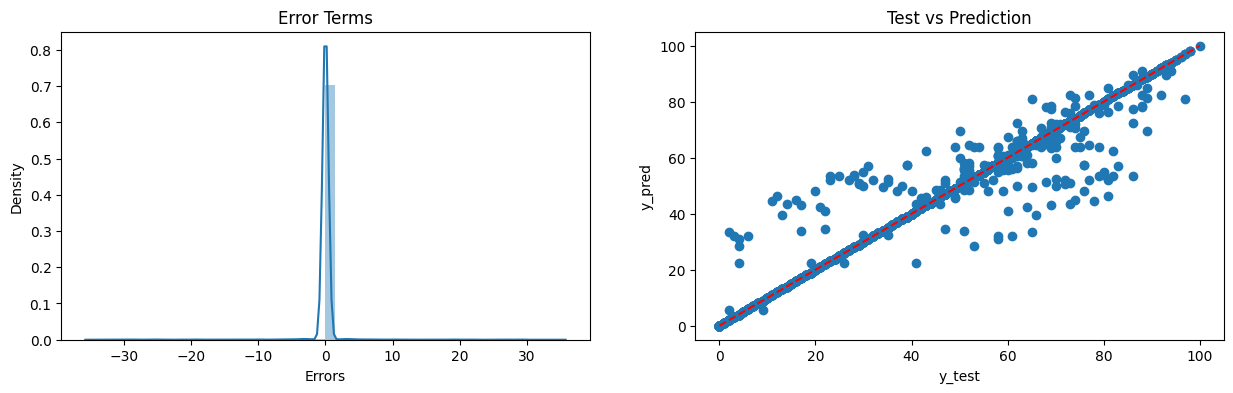

In [ ]:
DTR = DecisionTreeRegressor().fit(X_train_std,y_train)
pred_train = DTR.predict(X_train_std)
pred_test = DTR.predict(X_test_std)

Evaluate(0, pred_train, pred_test)

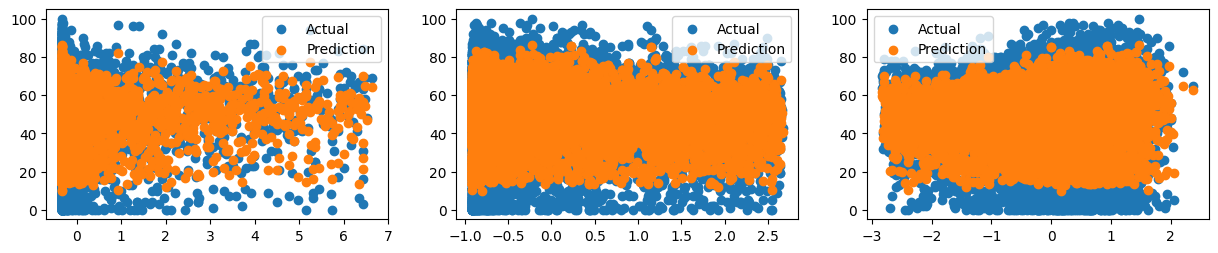



Training Set Metrics

R2-Score on Training set:                           0.852477206606076
Mean Squared Error (MSE) on Training set:           63.0628285087687
Root Mean Squared Error (RMSE) on Training set:     7.94121077095733


Testing Set Metrics

R2-Score on Testing set:                           -0.042834826923265235
Mean Squared Error (MSE) on Testing set:           435.58542044778176
Root Mean Squared Error (RMSE) on Testing set:     20.87068327697447


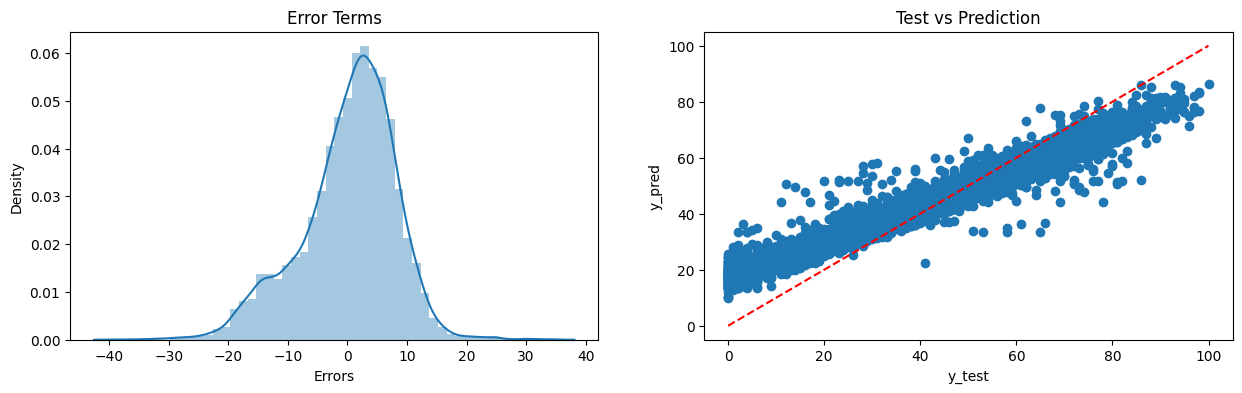

In [ ]:
RFR = RandomForestRegressor().fit(X_train_std, y_train)
pred_train = RFR.predict(X_train_std)
pred_test = RFR.predict(X_test_std)

Evaluate(1, pred_train, pred_test)

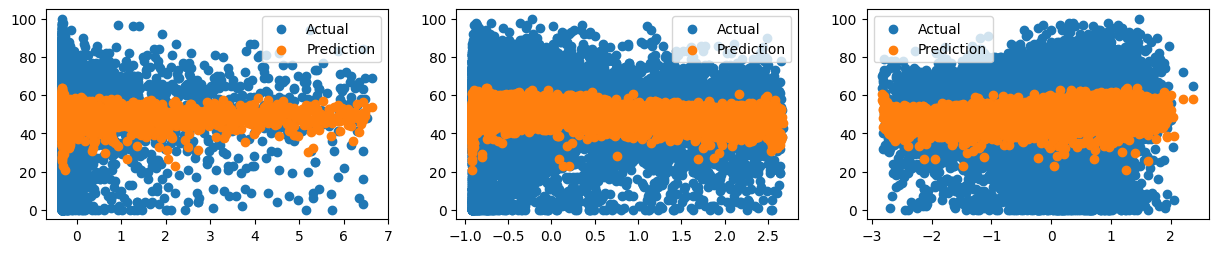



Training Set Metrics

R2-Score on Training set:                           0.13906450520250024
Mean Squared Error (MSE) on Training set:           368.03144935406874
Root Mean Squared Error (RMSE) on Training set:     19.18414578119309


Testing Set Metrics

R2-Score on Testing set:                           0.01099303908591398
Mean Squared Error (MSE) on Testing set:           413.10186596524596
Root Mean Squared Error (RMSE) on Testing set:     20.32490752660995


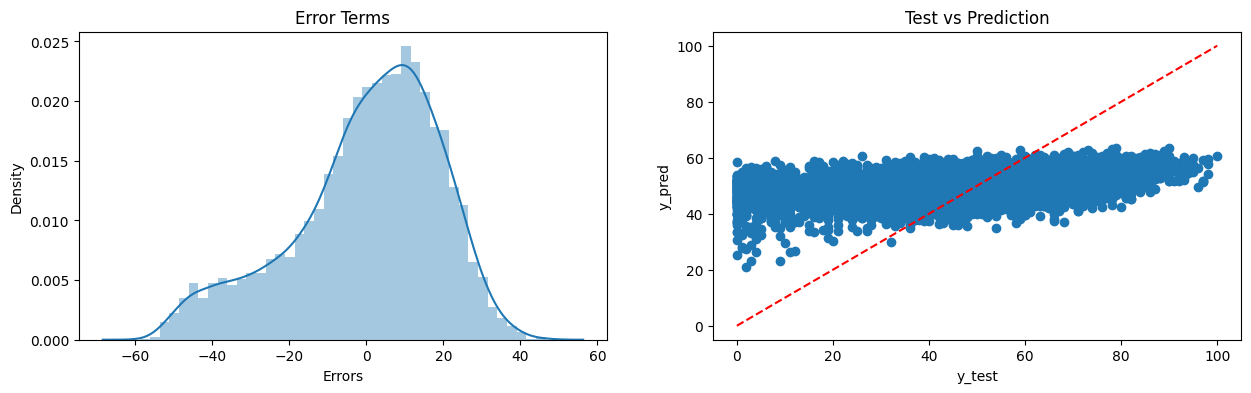

In [ ]:
GBR = GradientBoostingRegressor().fit(X_train_std, y_train)
pred_train = GBR.predict(X_train_std)
pred_test = GBR.predict(X_test_std)

Evaluate(2, pred_train, pred_test)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model = CatBoostRegressor().fit(X_train_std, y_train)

Learning rate set to 0.05588
0:	learn: 20.6328446	total: 65ms	remaining: 1m 4s
1:	learn: 20.6037021	total: 70.1ms	remaining: 35s
2:	learn: 20.5661521	total: 74.9ms	remaining: 24.9s
3:	learn: 20.5234454	total: 80.2ms	remaining: 20s
4:	learn: 20.5051099	total: 85.6ms	remaining: 17s
5:	learn: 20.4680807	total: 91ms	remaining: 15.1s
6:	learn: 20.4340318	total: 95.9ms	remaining: 13.6s
7:	learn: 20.4037130	total: 101ms	remaining: 12.5s
8:	learn: 20.3843409	total: 106ms	remaining: 11.7s
9:	learn: 20.3546888	total: 111ms	remaining: 11s
10:	learn: 20.3282504	total: 116ms	remaining: 10.4s
11:	learn: 20.3042929	total: 121ms	remaining: 9.93s
12:	learn: 20.2850476	total: 126ms	remaining: 9.53s
13:	learn: 20.2684119	total: 131ms	remaining: 9.22s
14:	learn: 20.2505101	total: 136ms	remaining: 8.92s
15:	learn: 20.2301203	total: 141ms	remaining: 8.68s
16:	learn: 20.2102399	total: 146ms	remaining: 8.45s
17:	learn: 20.1936815	total: 152ms	remaining: 8.28s
18:	learn: 20.1753374	total: 156ms	remaining: 8.06

In [ ]:
pred_train = model.predict(X_train_std)
pred_test = model.predict(X_test_std)

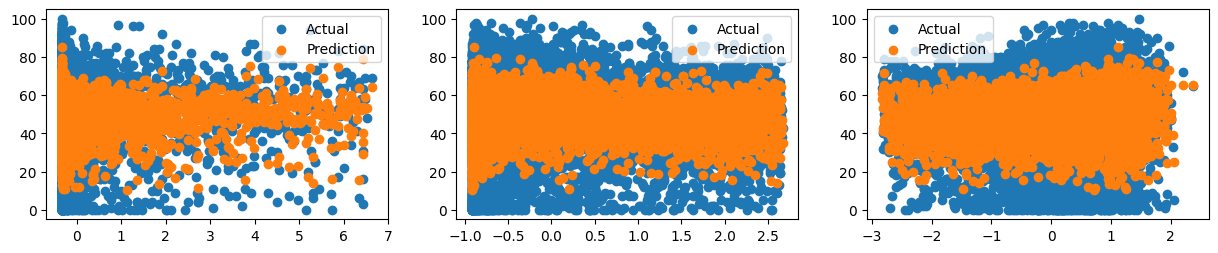



Training Set Metrics

R2-Score on Training set:                           0.5182989202415972
Mean Squared Error (MSE) on Training set:           205.91687485321197
Root Mean Squared Error (RMSE) on Training set:     14.349804000515546


Testing Set Metrics

R2-Score on Testing set:                           -0.04343049161457624
Mean Squared Error (MSE) on Testing set:           435.8342257698828
Root Mean Squared Error (RMSE) on Testing set:     20.87664306754998


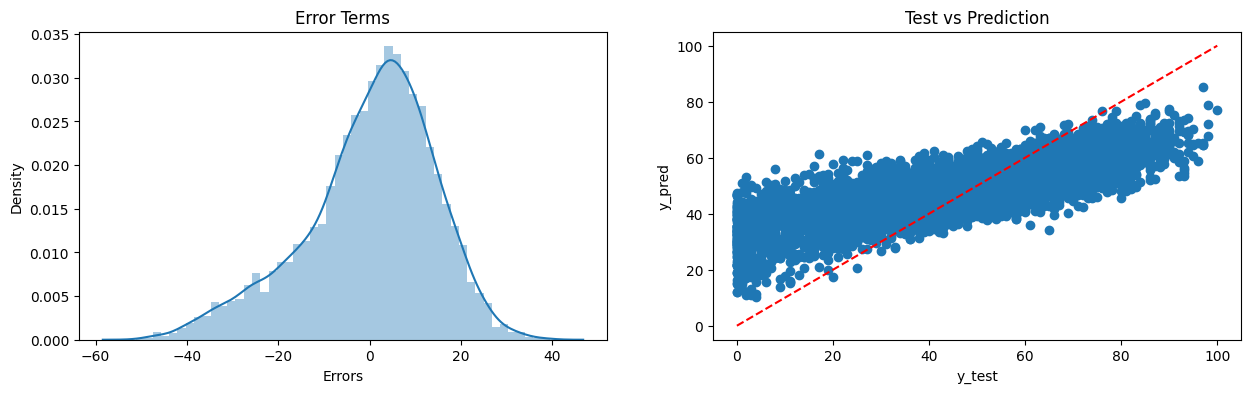

In [ ]:
Evaluate(-1, pred_train, pred_test)

Будем тестировать собственные реализации на более маленьких выборках.

##### Own KNN

In [54]:
import numpy as np

class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = []

        for x in X:
            distances = self._compute_distances(x)
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_values = self.y_train[k_indices]
            predictions.append(np.mean(k_nearest_values))

        return np.array(predictions)

    def _compute_distances(self, x):
        return np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

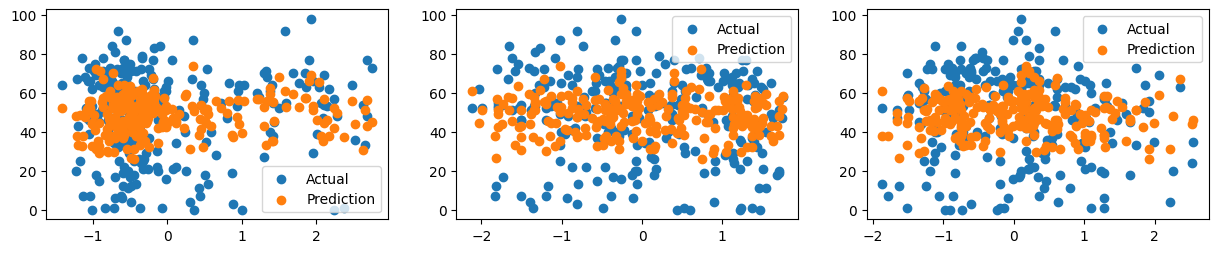



Training Set Metrics

R2-Score on Training set:                           0.1792559343076252
Mean Squared Error (MSE) on Training set:           401.67904000000004
Root Mean Squared Error (RMSE) on Training set:     20.041932042595096


Testing Set Metrics

R2-Score on Testing set:                           -0.2920140877417383
Mean Squared Error (MSE) on Testing set:           657.35008
Root Mean Squared Error (RMSE) on Testing set:     25.638839287300037


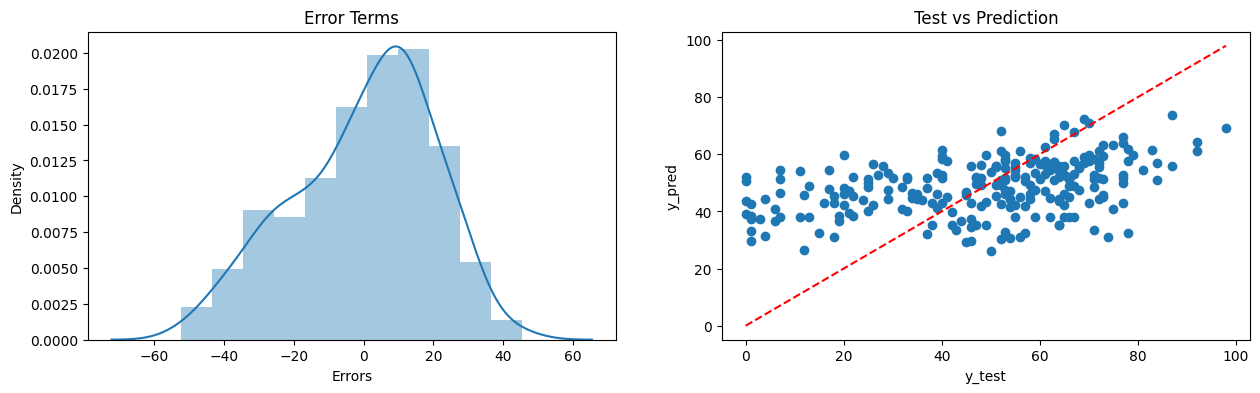

In [56]:
KNN = KNNRegressor()
KNN.fit(X_train_std[:250], y_train[:250])
pred_train = KNN.predict(X_train_std[:250])
pred_test = KNN.predict(X_test_std[:250])

EvaluateS(3, pred_train, pred_test, 250)

##### Own Decision Tree

In [ ]:
class OwnDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if self.max_depth is not None and depth == self.max_depth or num_samples == 1:
            return {'value': np.mean(y)}
        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return {'value': np.mean(y)}
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {'feature_index': best_feature,
                'threshold': best_threshold,
                'left': left_subtree,
                'right': right_subtree}

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        if num_samples <= 1:
            return None, None
        current_variance = np.var(y)
        best_variance = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            unique_values = np.unique(X[:, feature_index])
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                left_variance = np.var(y[left_mask])
                right_variance = np.var(y[right_mask])
                weighted_variance = (np.sum(left_mask) * left_variance + np.sum(right_mask) * right_variance) / num_samples
                if weighted_variance < best_variance:
                    best_variance = weighted_variance
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def predict(self, X):
        return np.array([self._predict_tree(sample, self.tree) for sample in X])

    def _predict_tree(self, x, node):
        if 'value' in node:
            return node['value']
        else:
            if x[node['feature_index']] <= node['threshold']:
                return self._predict_tree(x, node['left'])
            else:
                return self._predict_tree(x, node['right'])

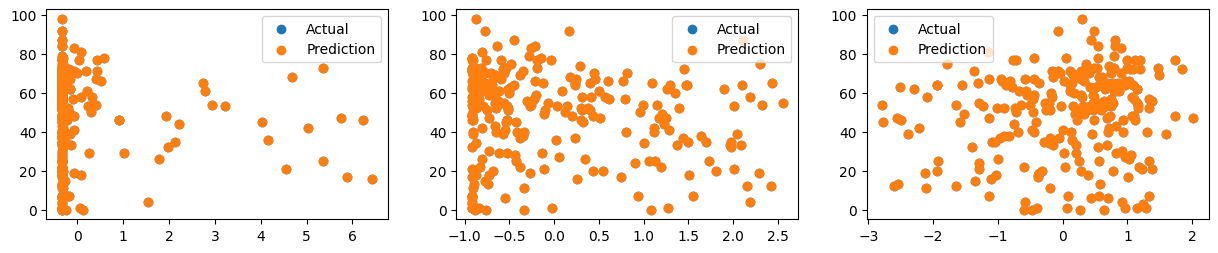



Training Set Metrics

R2-Score on Training set:                           1.0
Mean Squared Error (MSE) on Training set:           0.0
Root Mean Squared Error (RMSE) on Training set:     0.0


Testing Set Metrics

R2-Score on Testing set:                           -1.1442222701556846
Mean Squared Error (MSE) on Testing set:           1090.936
Root Mean Squared Error (RMSE) on Testing set:     33.02932030787191


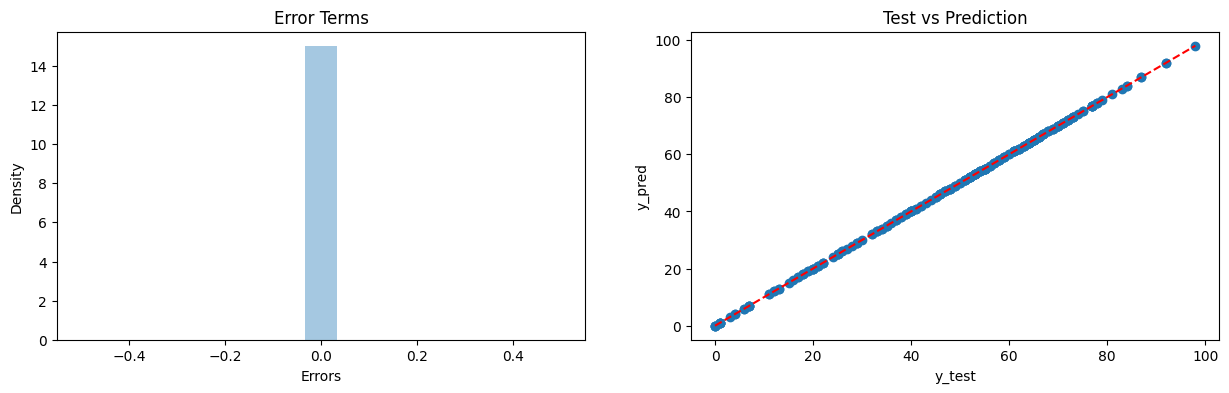

In [ ]:
ODT = OwnDecisionTreeRegressor()
ODT.fit(X_train_std[:250], y_train[:250])
pred_train = ODT.predict(X_train_std[:250])
pred_test = ODT.predict(X_test_std[:250])

EvaluateS(3, pred_train, pred_test, 250)

##### Own Random Forest

In [ ]:
class OwnRandomForestRegressor:
    def __init__(self, n_trees=10, max_depth=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_subset, y_subset = X[indices], y[indices]
            tree = OwnDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        mean_predictions = np.mean(predictions, axis=0)
        return mean_predictions

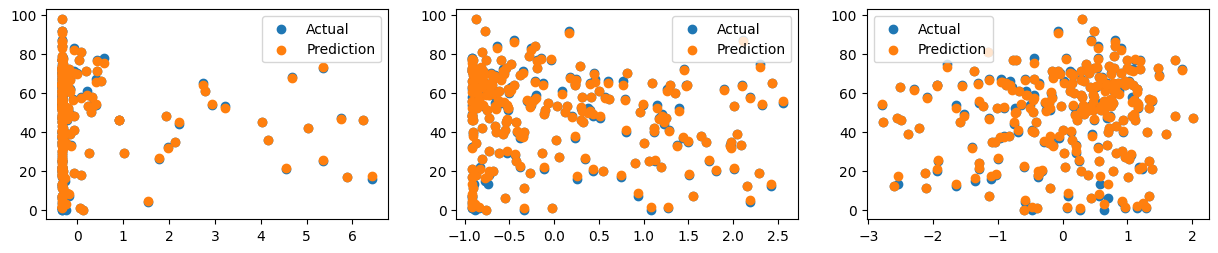



Training Set Metrics

R2-Score on Training set:                           0.9983111320795297
Mean Squared Error (MSE) on Training set:           0.8265461467687079
Root Mean Squared Error (RMSE) on Training set:     0.9091458336090574


Testing Set Metrics

R2-Score on Testing set:                           -0.16201832928368942
Mean Squared Error (MSE) on Testing set:           591.2109232889314
Root Mean Squared Error (RMSE) on Testing set:     24.314829287678155


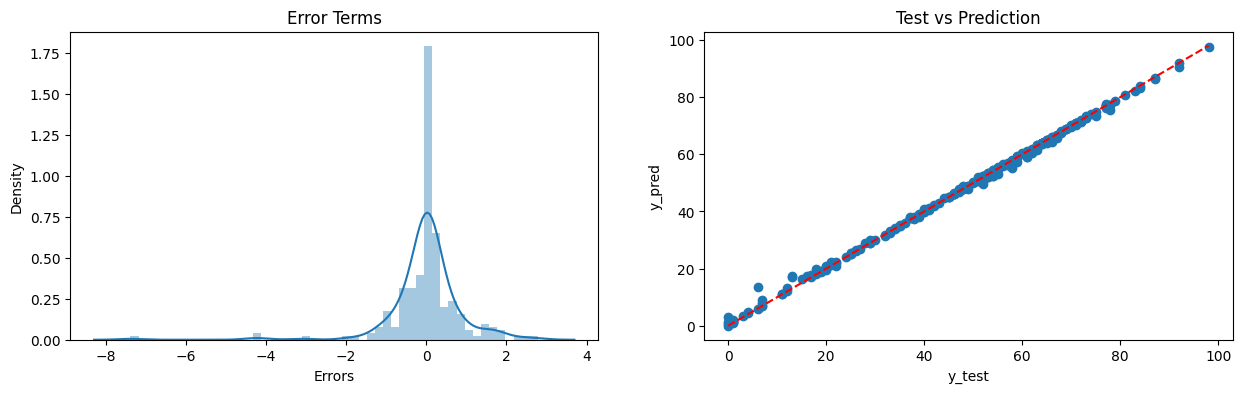

In [ ]:
ORF = OwnRandomForestRegressor()
ORF.fit(X_train_std[:250], y_train[:250])
pred_train = ORF.predict(X_train_std[:250])
pred_test = ORF.predict(X_test_std[:250])

EvaluateS(4, pred_train, pred_test, 250)

##### Own Gradient Boosting

In [ ]:
class OwnGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        predictions = np.full_like(y, np.mean(y), dtype=np.float64)
        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = OwnDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * tree_predictions
            self.models.append(tree)

    def predict(self, X):
        predictions = np.full(X.shape[0], np.mean([tree.predict(X) for tree in self.models]), dtype=np.float64)
        for tree in self.models:
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * tree_predictions
        return predictions

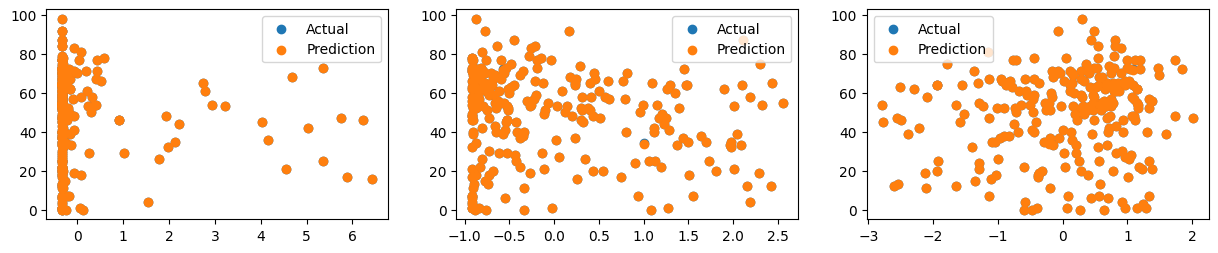



Training Set Metrics

R2-Score on Training set:                           0.9999999751163119
Mean Squared Error (MSE) on Training set:           1.217828597530874e-05
Root Mean Squared Error (RMSE) on Training set:     0.00348974010139849


Testing Set Metrics

R2-Score on Testing set:                           -0.30630744501095153
Mean Squared Error (MSE) on Testing set:           664.6222449349881
Root Mean Squared Error (RMSE) on Testing set:     25.780268519450843


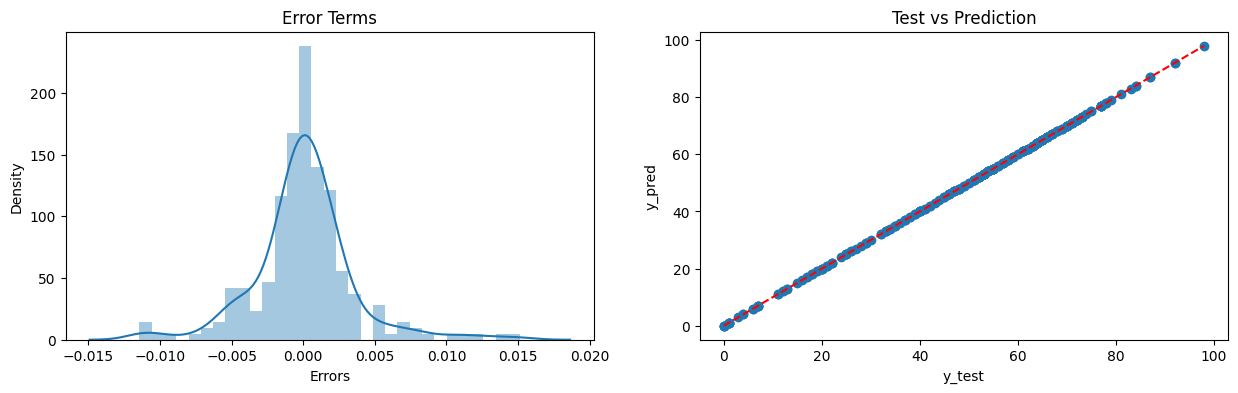

In [ ]:
OGBR = OwnGradientBoostingRegressor()
OGBR.fit(X_train_std[:250], y_train[:250])
pred_train = OGBR.predict(X_train_std[:250])
pred_test = OGBR.predict(X_test_std[:250])

EvaluateS(5, pred_train, pred_test, 250)